# Jupyter notebook that creates a figure illustrating the idea of mutation fraction surviving
This Jupyter notebook uses `R` to create a plot that illustrates the idea of fraction of a mutation surviving selection as implemented in the `fracsurvive` programs of [dms_tools2](https://github.com/jbloomlab/dms_tools2).

Notebook created by Jesse Bloom.


## Setup variables and install the required packages
We use [ggplot2](http://ggplot2.tidyverse.org/) for the plotting and [ggseqlogo](https://omarwagih.github.io/ggseqlogo/) for the logo plots.

In [1]:
require("pacman", quietly=TRUE)
pacman::p_load('ggseqlogo', 'ggplot2', 'cowplot', 'dplyr', 'reshape2',
  'IRdisplay', 'stringr', 'Matrix', 'tidyr', 'scales')
sessionInfo()

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_0.4.1    tidyr_0.6.3     Matrix_1.2-10   stringr_1.2.0  
 [5] IRdisplay_0.4.4 reshape2_1.4.2  dplyr_0.7.1     cowplot_0.7.0  
 [9] ggplot2_2.2.1   ggseqlogo_0.1   pacman_0.4.6   

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11        compiler_3.4.0      plyr_1.8.4         
 [4] bindr_0.1           tools_3.4.0         digest_0.6.12      
 [7] uuid_0.1-2          lattice_0.20-35     jsonlite_1.5       
[10] evaluate_0.10       tibble_1.3.3        gtable_0.2.0       
[13

Functions for saving / showing images and labeling axes:

In [2]:
saveShowPlot <- function(p, width, height) {
  # save plot with filename of variable name with dots replaced by _, then show
  pngfile <- file.path(sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  pdffile <- file.path(sprintf("%s.pdf", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

Set up the color-blind palette described [here][1]:

   [1]: http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette

In [3]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                "#0072B2", "#D55E00", "#CC79A7")

## Plot neutralization curves
First, we define a sigmoid neutralization curve function:

In [4]:
#' Sigmoidal neutralization curve
#'
#' Returns fraction infectivity remaining at concentration
#' @param c concentration of antibody
#' @param ic50 IC50 of antibody
#' @alpha the "slope" parameter of the sigmoid
neutcurve <- function(c, ic50, alpha=0.35, percent=TRUE) {
  1 - exp((c - ic50) / alpha) / (1 + (exp((c - ic50) / alpha)))
}

Range of log concentrations over which we will plot:

In [5]:
logcmin <- -4
logcmax <- 1
logcdelta <- 0.01 # interval to calculate values
logc <- seq(from=logcmin, to=logcmax, by=logcdelta)

Now set up function that draws neutralization curves and associated logo plots:

In [6]:
#' plot neutralization curves and logo plots
#'
#' Returns list containing neut curve, list of logo plots
#' @param variants vector of variant names
#' @param ic50s vector of IC50 values
#' @param seqs vector seqs for each variant, first one is wildtype
#' @param conc vector of concentrations at which to draw vertical lines
#' @param colscheme color scheme for logo plots 
plotcurvesandlogo <- function(variants, ic50s, seqs, conc, colscheme) {
  # dataframe giving fraction survive for each antibody at each concentration
  wtseq <- seqs[[1]]
  sites <- seq(1, nchar(wtseq))
  neutdata <- data.frame(logc)  %>%
    merge(data.frame(variant=variants, ic50=ic50s, seq=seqs)) %>%
    merge(data.frame(site=sites)) %>%
    transform(variant=factor(variant, levels=variants)) %>%
    mutate(fracsurvive=neutcurve(logc, ic50), 
      c=10**logc, 
      aa=str_sub(seq, site, site), 
      wt=str_sub(wtseq, site, site))
    
  # neutralization curve plot
  p.neut <- ggplot(neutdata, aes(x=c, y=fracsurvive, color=variant)) +
    geom_line(size=0.7) +
    scale_y_continuous('fraction infectivity', breaks=c(0, 0.5, 1)) +
    scale_x_log10(expression(paste('antibody concentration (', mu, 'g/ml)')), 
      labels=fancy_scientific) +
    scale_color_manual('', values=cbbPalette) +
    geom_vline(aes(xintercept=conc), data=data.frame(conc), color=tail(cbbPalette, n=1),
      linetype='dotted', size=1) +
    theme(legend.position='top', axis.text.x=element_text(vjust=0.1),
      axis.text=element_text(size=12), axis.title=element_text(size=13),
      plot.margin=unit(c(0, 0.6, 0, 0), 'in'))
    
  # make sequence logo
  # first make named list of matrices
  mat.list <- lapply(conc,
    function (concline) {
      # create matrix with frac surviving data
      mat <- neutdata %>%
        filter(abs(c - concline) == min(abs(c - concline))) %>%
        filter((wt != aa) | (seq == wtseq)) %>%
        dcast(site ~ aa, value.var='fracsurvive', fill=0) %>% 
        as.matrix %>%
        t
    }
    ) %>%
    setNames(c('low antibody\nconcentration', 'middle antibody\nconcentration', 
      'high antibody\nconcentration'))
  # now make logo plot  
  p.logo <- ggseqlogo(mat.list, method='custom', col_scheme=colscheme) +
    scale_y_continuous('fraction surviving', breaks=NULL) +
    scale_x_continuous('site') + 
    theme(panel.spacing=unit(1.5, 'lines'), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=13), 
      strip.text=element_text(size=13),
      axis.line.x=element_line(color='black'), 
      plot.margin=unit(c(0.05, 0, 0.23, 0.1), 'in'))
    
  return(list(p.neut, p.logo))
}

Merge together into the final plot:

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


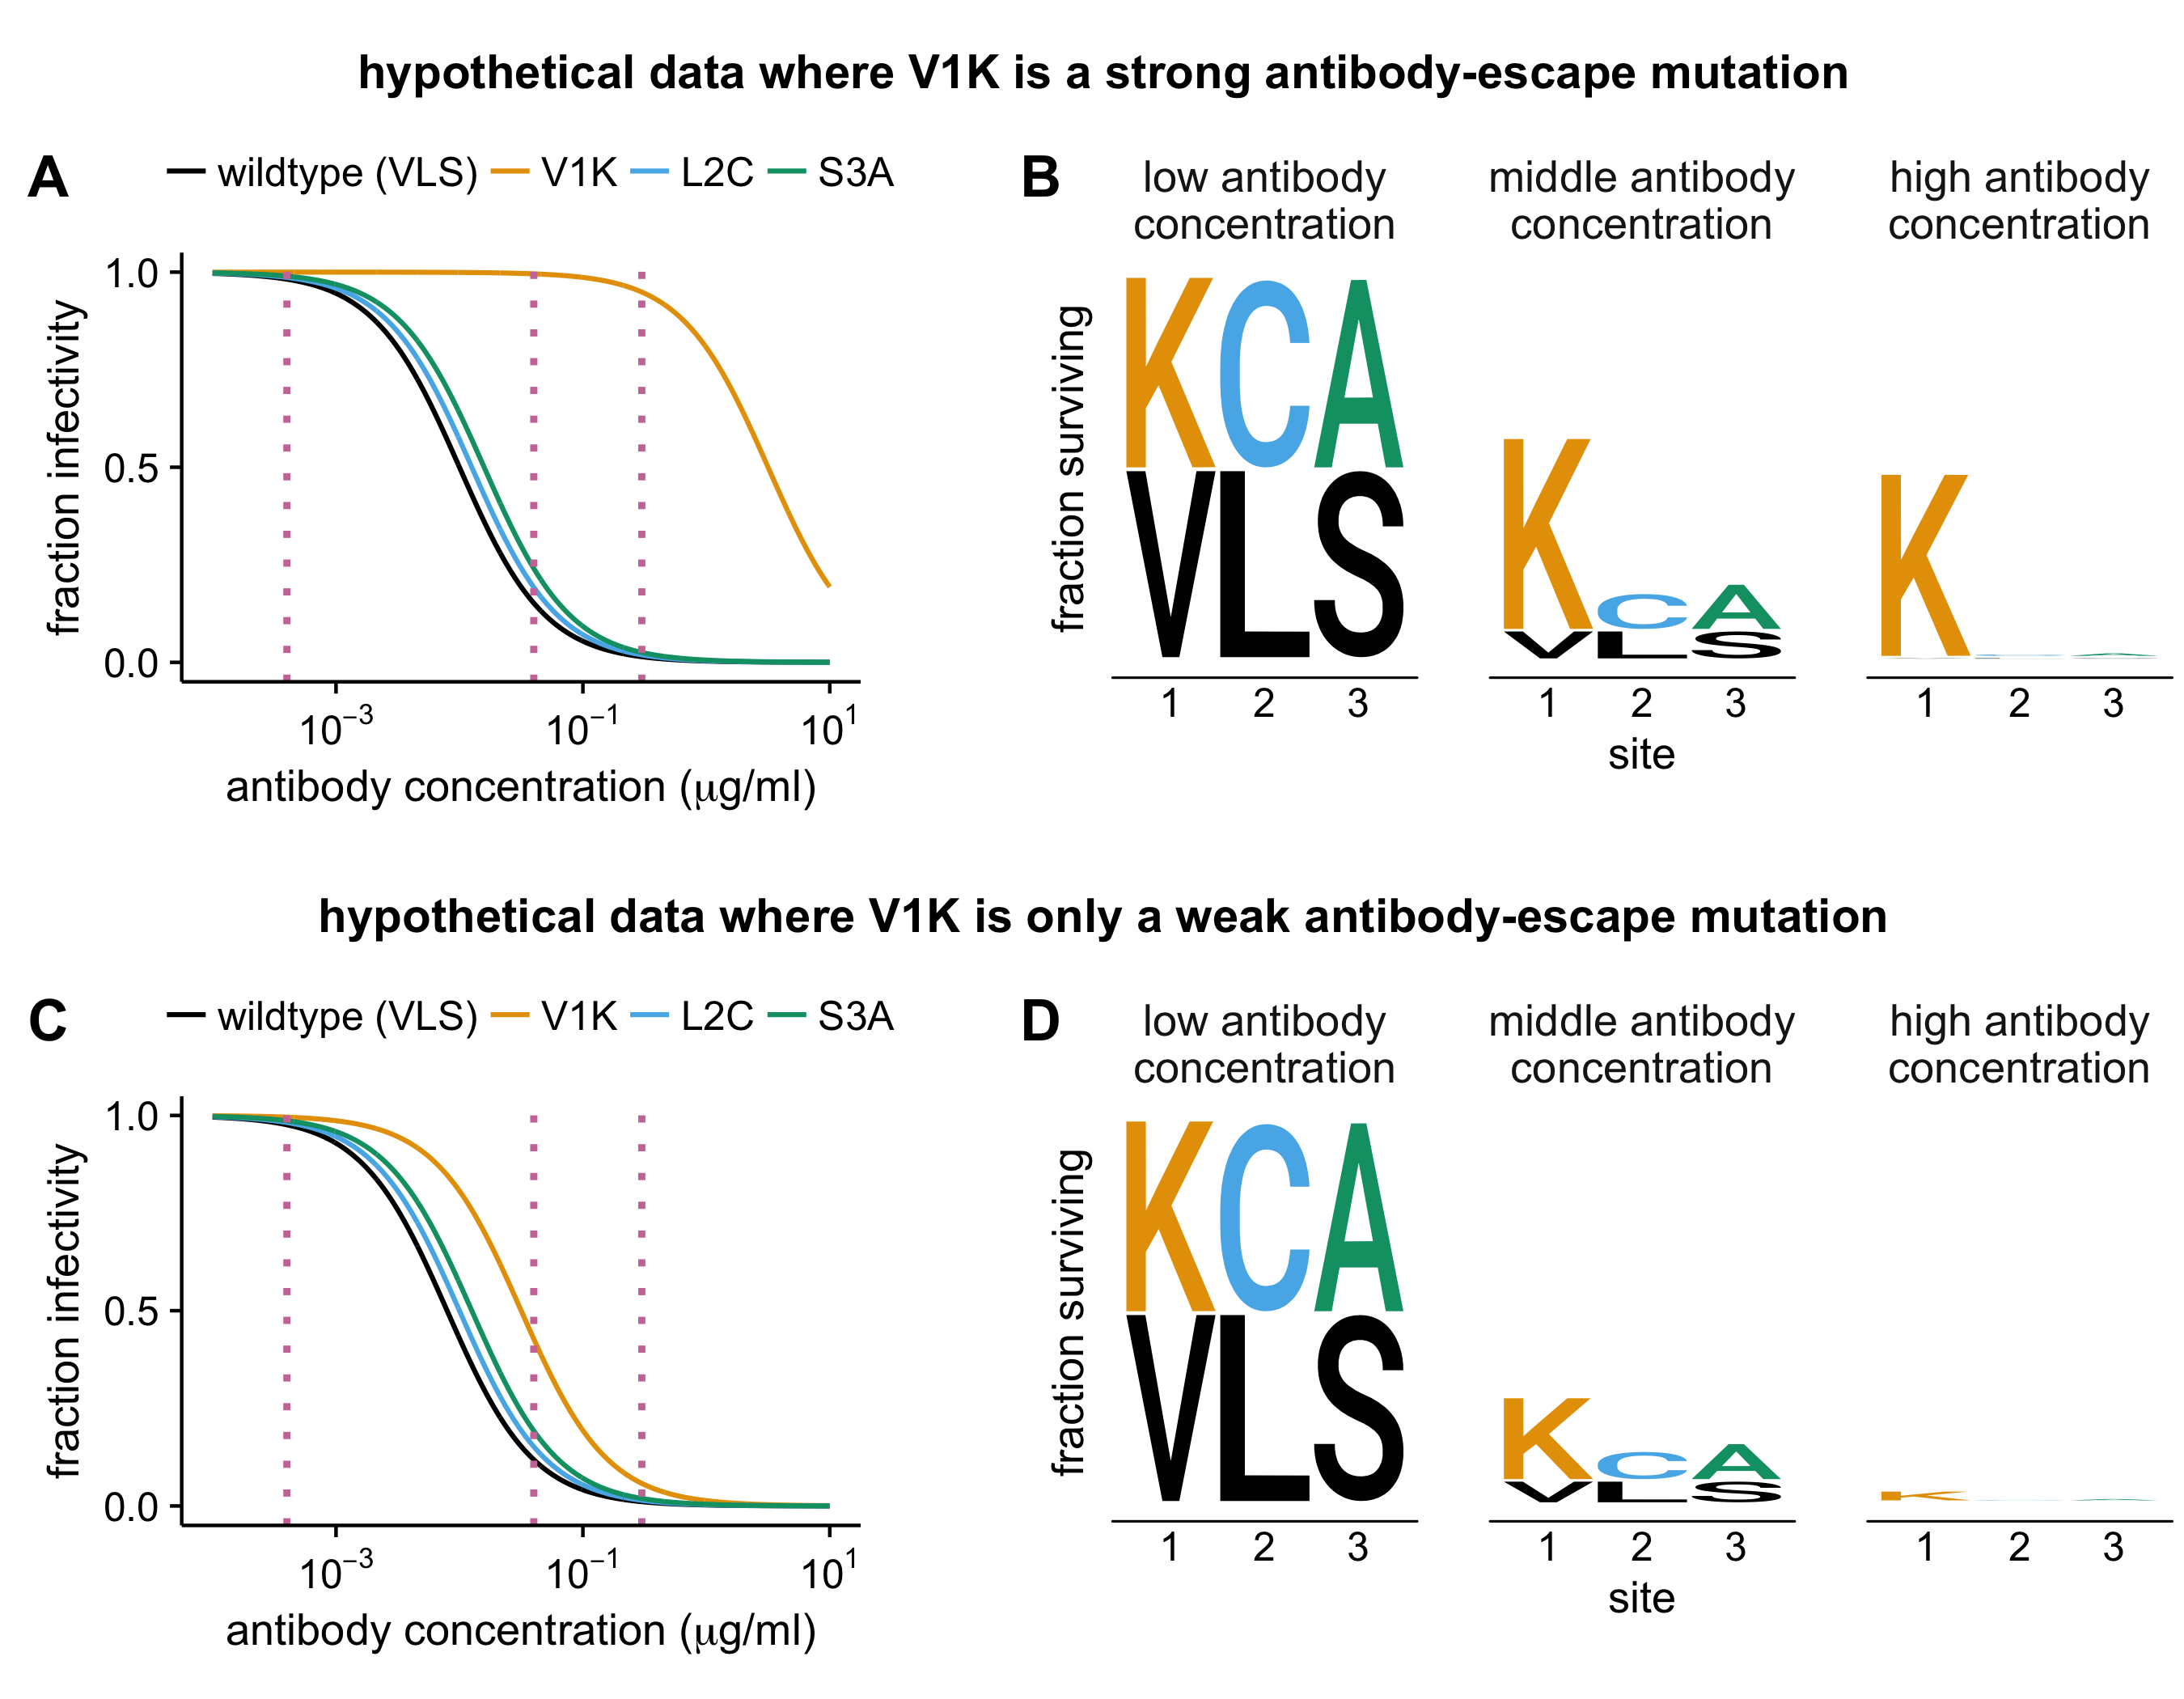

In [7]:
variants <- c('wildtype (VLS)', 'V1K', 'L2C', 'S3A')
seqs <- c('VLS', 'KLS', 'VCS', 'VLA')

# color scheme for logo plots
colscheme <- make_col_scheme(
  chars=c('V', 'L', 'S', 'K', 'C', 'A'),
  cols=c(cbbPalette[[1]], cbbPalette[[1]], cbbPalette[[1]], 
    cbbPalette[[2]], cbbPalette[[3]], cbbPalette[[4]]))

# draw logo plots for these concentrations
conc <- c(4e-4, 4e-2, 3e-1)

# plots for easy to escape antibody
p.easy <- plotcurvesandlogo(
    variants=variants,
    ic50s=c(-2, 0.5, -1.9, -1.8),
    seqs=seqs,
    conc=conc,
    colscheme=colscheme)
p.merge.easy <- plot_grid(p.easy[[1]], p.easy[[2]], ncol=2, rel_widths=c(1.7, 2), 
  scale=0.98, labels=c('A', 'B'), label_size=17, hjust=-0.1) 

# plots for hard to escape antibody
p.hard <- plotcurvesandlogo(
    variants=variants,
    ic50s=c(-2.1, -1.5, -2, -1.9),
    seqs=seqs,
    conc=conc,
    colscheme=colscheme)
p.merge.hard <- plot_grid(p.hard[[1]], p.hard[[2]], ncol=2, rel_widths=c(1.7, 2), 
  scale=0.98, labels=c('C', 'D'), label_size=17, hjust=-0.1) 

# merge into a titled plot
title.easy <- ggdraw() + draw_label("hypothetical data where V1K is a strong antibody-escape mutation", 
  fontface='bold', size=14, vjust=1)
title.hard <- ggdraw() + draw_label("hypothetical data where V1K is only a weak antibody-escape mutation", 
  fontface='bold', size=14, vjust=1)
frac.survive.example.plot <- plot_grid(
  title.easy, p.merge.easy, title.hard, p.merge.hard, 
  ncol=1, rel_heights=c(0.5, 3, 0.5, 3))
saveShowPlot(frac.survive.example.plot, 9, 7)